# 问题
$-u^{''}(x)=f(x), u(0)=u(1)=0$

其中
$f(x) = -(2\cos x-(x-1)\sin x)$

真解
$u(x) = x\sin x$

In [71]:
import numpy as np

# 划分网格
N = 100
x0 = 0
x1 = 1 
x = np.linspace(x0, x1, N+2) # cell edges
# xc = (x[1:] + x[:-1]) / 2   # cell centers

global dx
dx = x[1] - x[0]

In [72]:
# 计算a(phi_i, phi_j)  
def a(phi1:int, phi2:int):
    if phi1 == phi2:
        return 2.0 / dx
    elif phi1 == phi2 + 1:
        return -1.0 / dx
    elif phi1 == phi2 - 1:
        return -1.0 / dx
    else:
        return 0


def f(x):
    return -(2*np.cos(x) - (x-1)*np.sin(x))

# 计算F(phi_i)
def F(phi:int):
    return f(x[phi]) * dx  #高斯积分

In [73]:
A = np.zeros((N, N))
B = np.zeros(N)
for i in range(N):
    for j in range(N):
        A[i, j] = a(i, j)
    B[i] = F(i)

In [74]:
k = np.linalg.solve(A, B)

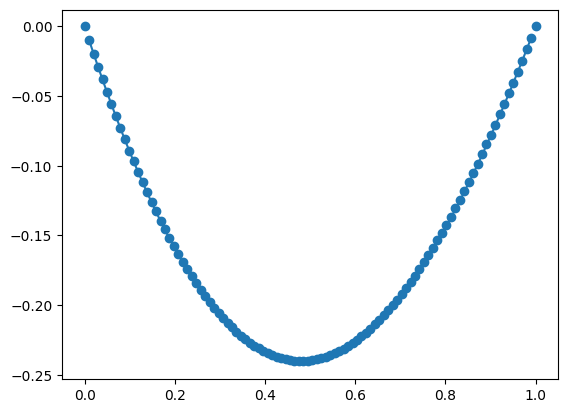

In [75]:
u_real = (x - 1) * np.sin(x)

import matplotlib.pyplot as plt
plt.plot(x[1:-1], k)
plt.scatter(x, u_real)
plt.show()

# DG
$\frac{\partial{u}}{\partial{t}} + \frac{\partial{f(u)}}{\partial{x}} = 0$

$u(x,0) = \sin x$

In [76]:
def init_data(): # 赋初值
    pass

def get_basic(): #基函数在Gauss点和端点的值
    pass

def L2_pro(): # L2投影
    pass

def RK3(): # RK3格式
    pass

def calc_L2_error(): # 计算L2误差
    pass

In [77]:
def get_GLP(NumGLP): # 获取高斯积分点和权重
    if(NumGLP == 5):
        point = np.array([-0.9061798459386640, -0.5384693101056831 ,0, 0.5384693101056831 , 0.9061798459386640])
        weight = np.array([0.2369268850561891, 0.4786286704993665, 0.5688888888888889,  0.4786286704993665,  0.2369268850561891])
        return point, weight

In [78]:
def f(x):
    return np.sin(x)

In [79]:
Nx = 100
k = 2 # 多项式阶数
NumGLP = 2*k + 1 # 高斯积分点数
dimPk = k + 1 # Pk空间维数
CFL = 0.1

xa = 0
xb = 2 * np.pi
bcL = 1
bcR = 1
t_end = 2 * np.pi

hx = (xb - xa) / Nx
h1 = hx / 2

x = np.linspace(xa, xb, Nx+1)
xc = np.linspace(xa + h1, xb - h1, Nx)

In [80]:
# 计算初值
u_real = np.zeros((Nx, NumGLP)) # Nx个单元，每个单元NumGLP个高斯点
point, weight = get_GLP(NumGLP) 
for i in range(Nx):
    for j in range(NumGLP):
        u_real[i, j] = f(xc[i] + h1 * point[j])

In [81]:
#基函数在Gauss点和端点的值
phi_Gauss = np.zeros((NumGLP,dimPk))
phi_grad_Gauss = np.zeros((NumGLP,dimPk))
phi_left = np.zeros(dimPk)
phi_right = np.zeros(dimPk)
mass = np.asarray([1, 1/3, 4/45])

# phi0 = 1
# phi1 = X
# phi2 = X^2 - 1/3

for i in range(NumGLP):
    phi_Gauss[i,0] = 1
    phi_grad_Gauss[i,0] = 0

    phi_Gauss[i,1] = point[i]
    phi_grad_Gauss[i,1] = 1 / h1

    phi_Gauss[i,2] = point[i] ** 2 - 1/3
    phi_grad_Gauss[i,2] = 2 * point[i] / h1

phi_left[0] = 1; phi_left[1] = -1; phi_left[2] = 2 / 3
phi_right[0] = 1; phi_right[1] = 1; phi_right[2] = 2 / 3

In [82]:
# 获取初值L2投影
uh = np.zeros((Nx, dimPk)) # 基函数系数

for i in range(Nx): # Nx个单元
    for j in range(dimPk): # dimPk个基函数
        uh[i,j] = 0
        for k in range(NumGLP): # NumGLP个高斯点
            uh[i,j] += u_real[i,k] * phi_Gauss[k,j] * weight[k]

for i in range(dimPk):
    uh[:,i] /= 2 * mass[i]

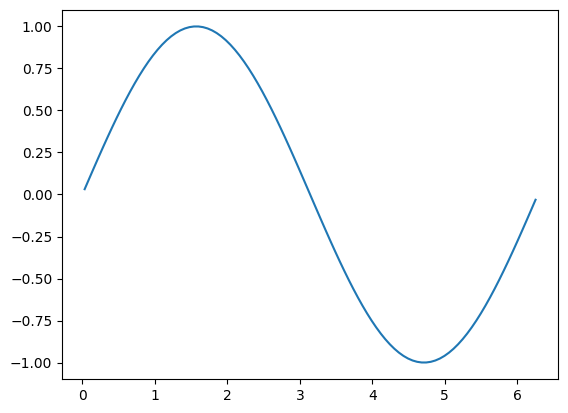

In [83]:
plt.plot(xc, uh[:,0])

In [84]:
def Lh(uh):
    
    # bc
    uhb = np.array([np.zeros(dimPk), *uh, np.zeros(dimPk)])
    if bcL == 1:
        uhb[0] = uh[-1]
    if bcR == 1:
        uhb[-1] = uh[0]

    # 计算内部积分项
    du = np.zeros((Nx, dimPk))
    uh_gauss = np.zeros((Nx, NumGLP))
    for i in range(Nx):
        for j in range(NumGLP):
            for k in range(dimPk):
                uh_gauss[i,j] += uh[i,k] * phi_Gauss[j,k]
    
    for i in range(Nx):
        for j in range(dimPk):
            for k in range(NumGLP):
                du[i,j] += 0.5 * weight[k] * (uh_gauss[i,k]) * phi_grad_Gauss[k,j]

    # 计算Flux
    uhL = np.zeros(Nx+1)
    uhR = np.zeros(Nx+1)

    for i in range(Nx+1):
        for j in range(dimPk):
            uhL[i] += uhb[i,j] * phi_left[j]
            uhR[i] += uhb[i+1,j] * phi_right[j]

    Flux = np.zeros(Nx+1)

    for i in range(Nx+1):
        uR = uhL[i]
        uL = uhR[i]
        alp = 1
        Flux[i] = 0.5 * (uR + uL - alp * (uR - uL))

    # 计算Lh

    Lh = np.zeros((Nx, dimPk))

    for i in range(Nx):
        for j in range(dimPk):
            Lh[i,j] = du[i,j] - (Flux[i+1] * phi_right[j] - Flux[i] * phi_left[j]) / hx


    for i in range(dimPk):
        Lh[:,i] /= mass[i]

    return Lh

In [85]:
dt = CFL * hx
t = 0

while t < t_end:
    t += dt
    
    delta_u = Lh(uh)
    uh += dt * delta_u

/tmp/ipykernel_34834/4165563783.py:50: RuntimeWarning: overflow encountered in divide
  Lh[:,i] /= mass[i]
/tmp/ipykernel_34834/4165563783.py:21: RuntimeWarning: invalid value encountered in scalar multiply
  du[i,j] += 0.5 * weight[k] * (uh_gauss[i,k]) * phi_grad_Gauss[k,j]
/tmp/ipykernel_34834/4165563783.py:21: RuntimeWarning: invalid value encountered in scalar add
  du[i,j] += 0.5 * weight[k] * (uh_gauss[i,k]) * phi_grad_Gauss[k,j]
/tmp/ipykernel_34834/4165563783.py:38: RuntimeWarning: invalid value encountered in scalar add
  Flux[i] = 0.5 * (uR + uL - alp * (uR - uL))
/tmp/ipykernel_34834/4165563783.py:38: RuntimeWarning: invalid value encountered in scalar subtract
  Flux[i] = 0.5 * (uR + uL - alp * (uR - uL))
/tmp/ipykernel_34834/4165563783.py:16: RuntimeWarning: invalid value encountered in scalar add
  uh_gauss[i,j] += uh[i,k] * phi_Gauss[j,k]
/tmp/ipykernel_34834/4165563783.py:16: RuntimeWarning: invalid value encountered in scalar multiply
  uh_gauss[i,j] += uh[i,k] * phi_G

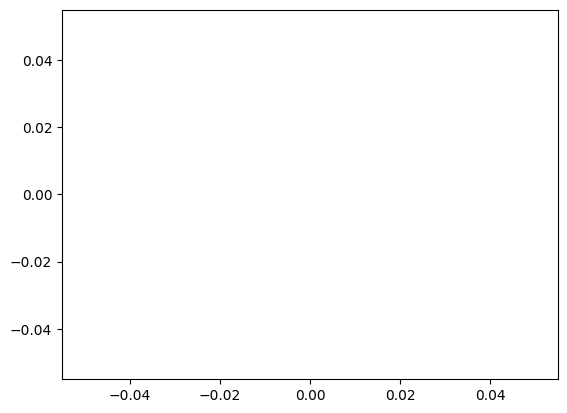

In [86]:
plt.plot(xc, uh[:,0])